# Bayesian Cubic Splines regression data analysis

In [1]:
from __future__ import print_function

In [2]:
import numpy as np
import pymc3 as pm
import theano.tensor as tt
import matplotlib.pyplot as plt

In [3]:
from scipy.interpolate import BSpline

In [4]:
N = 50
x = np.linspace(0., 10., N)
noise = np.random.randn(N)*5.
y = 2. + 0.5*x + x**1.67 + noise

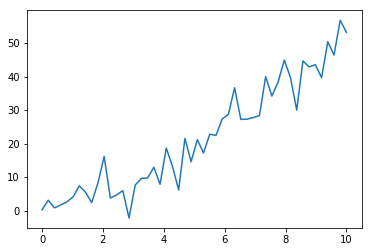

In [5]:
plt.plot(x,y);

In [45]:
cp = np.asarray([xo+1. for xo in  x[::5]])  # cutpoints
cp.round(3)

array([ 1.   ,  2.02 ,  3.041,  4.061,  5.082,  6.102,  7.122,  8.143,
        9.163, 10.184])

## Picewise linear regression

Step functions

In [103]:
# indicator functions
def indicator_function(x, c1, c2):
    all_zeros = np.zeros_like(x)
    if c2 == None:
        all_zeros[np.where(x<c1)] = 1.
    elif c1 == None:
        all_zeros[np.where(x>=c2)] = 1.
    else:
        all_zeros[np.where((x>=c1) & (x<c2))] = 1.
    return all_zeros

In [104]:
C0 = indicator_function(x, cp[0], None)
Ci = np.asarray([indicator_function(x, cp[i], cp[i+1]) for i in range(0, len(cp)-1)])
CK = indicator_function(x, None, cp[-1])
C = np.c_[C0, Ci.T, CK]

In [105]:
X = np.c_[x, x**2, x**3]

In [114]:
with pm.Model() as picewise:
    betai = pm.Normal('betai', mu=0., sd=100., shape=len(cp)+1)
    #betak = pm.Normal('betak', mu=0., sd=100., shape=3)
    mu = pm.Deterministic('mu', pm.math.dot(C, betai) )#+ pm.math.dot(X, betak))
    sd = pm.HalfCauchy('sd', beta=10)
    yi = pm.Normal('yhat', mu=mu, sd=sd, observed=y)
    chain = pm.sample(draws=10000, tune=1000, chains=2, nuts_kwargs={'target_accept':0.95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sd, betai]


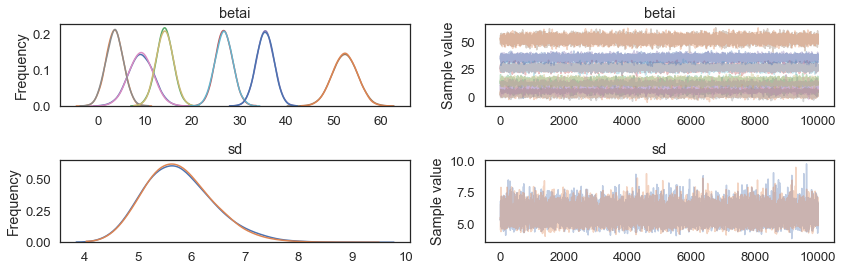

In [115]:
pm.traceplot(chain, varnames=['betai', 'sd']);

In [116]:
betai_est = chain.get_values(varname='betai', burn=100, thin=2, combine=True)
#betak_est = chain.get_values(varname='betak', burn=100, thin=2, combine=True)
betai_est_mean = betai_est.mean(axis=0)
yest = np.dot(C, betai_est_mean) #+ np.dot(X, betak_est.mean(axis=0))
betai_hpd = pm.hpd(betai_est, alpha=0.1)
yhpd_min = np.dot(C, betai_hpd[:,0])
yhpd_max = np.dot(C, betai_hpd[:,1])

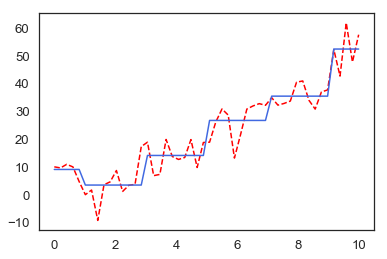

In [117]:
plt.plot(x, y, ls='--', c='red')
plt.plot(x, yest, ls='-', c='royalblue')
#plt.fill_between(x, yhpd_min, yhpd_max, color='royalblue', alpha=0.5)
plt.show()

## Kernelized regression

In [15]:
# we also want kernels on the endpoints of the data
centroids = np.r_[x[0], cp, x[-1]]

In [16]:
# Radial basis function (Gaussian kernel)
def rbf(x, x0, sigma):
    kernel = np.exp(-(x-x0)**2/(2.*sigma**2))
    return kernel

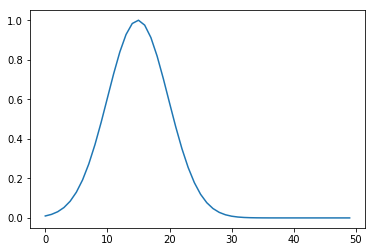

In [18]:
a = rbf(x, centroids[2], 1.)
plt.plot(a);

In [19]:
# kernelised feature vector (with manual rbf kernel function)
X_kern = np.asarray([rbf(x, x0, sigma=1.) for x0 in centroids]).T
X_kern.shape

(50, 5)

In [ ]:
# Linear kernel
def linear(x, x0, c):
    kernel = np.dot(x.T, x0) + c
    return kernel

In [25]:
# Polynomial kernel
def polynomial(x, x0, a, c, d):
    """
    a - slope
    c - constant term
    d - polynomial degree
    """
    kernel = (a*np.dot(x.T, x0) + c)**d
    return kernel

In [7]:
# Rational Quadratic Kernel
def rational_quadratic(x, x0, c):
    kernel = 1. - (x-x0)**2/((x-x0)**2 + c)
    return kernel

In [20]:
# kernelised feature vector (rational quadratic kernel)
X_kern = np.asarray([rational_quadratic(x, x0, c=1.) for x0 in centroids]).T
X_kern.shape

(50, 7)

In [ ]:
# Gaussian kernel
def gaussian(x, xo, gamma):
    kernel = np.exp(-gamma*(x-x0)**2)
    return kernel

In [ ]:
# Exponential kernel
def exponential(x, x0, sigma):
    kernel = np.exp(-np.sqrt((x-x0)**2)/(2.*sigma))
    return kernel

In [ ]:
# Laplacian kernel
def laplacian(x, x0, sigma):
    kernel = np.exp(-np.sqrt((x-x0)**2)/sigma)
    return kernel

In [ ]:
# Generalized T-Student Kernel
def student_t(x, x0, d):
    kernel = 1./(1. + (x-x0)**d)
    return kernel

In [43]:
# using kernels from scikit-learn:
from sklearn.metrics import pairwise
# pairwise.chi2_kernel - Computes the exponential chi-squared kernel
# pairwise.laplacian_kernel - Compute the laplacian kernel
# pairwise.linear_kernel - Compute the linear kernel
# pairwise.polynomial_kernel - Compute the polynomial kernel
# pairwise.rbf_kernel - Compute the rbf (gaussian) kernel
# pairwise.sigmoid_kernel - Compute the sigmoid kernel

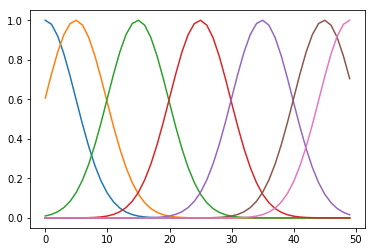

In [38]:
# kernelized feature vector (scikit-learn: rbf_kernel)
X_kern = pairwise.rbf_kernel(x.reshape(-1,1), centroids.reshape(-1,1), gamma=0.5)  # reshape for single feature
plt.plot(X_kern);

In [39]:
with pm.Model() as picewise:
    betai = pm.Normal('betai', mu=0., sd=100., shape=len(centroids))
    mu = pm.Deterministic('mu', pm.math.dot(X_kern, betai))
    sd = pm.HalfCauchy('sd', beta=10)
    yi = pm.Normal('yhat', mu=mu, sd=sd, observed=y)
    chain = pm.sample(draws=10000, tune=1000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sd, betai]


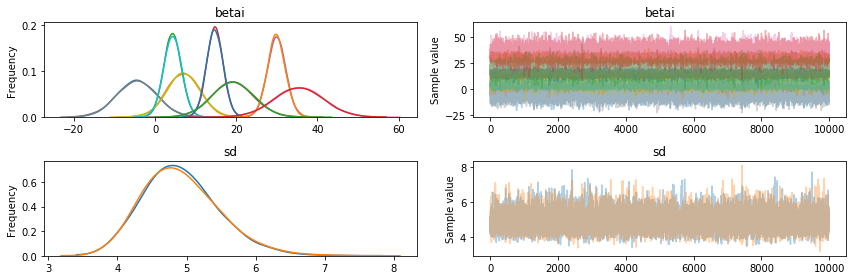

In [40]:
pm.traceplot(chain, varnames=['betai', 'sd']);

In [41]:
betai_est = chain.get_values(varname='betai', burn=1000, thin=2, combine=True)
y_est = np.dot(X_kern, betai_est.mean(axis=0))

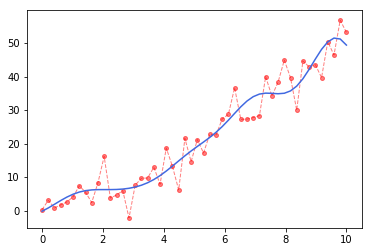

In [42]:
plt.plot(x, y, ls='--', c='red', marker='o', markersize=4, alpha=0.5, lw=1)
plt.plot(x, y_est, ls='-', c='royalblue')
plt.show()

## Regression splines (manual)

The Spline Basis Representation

In [66]:
def truncated_power_basis(x, ksi):
    all_zeros = np.zeros_like(x)
    all_zeros[np.where(x>ksi)] = (x[np.where(x>ksi)] - ksi)**3
    return all_zeros

In [201]:
# Basis splines
K = np.asarray([truncated_power_basis(x, c) for c in cp]).reshape((len(x), -1))

In [94]:
def boundary_condition(x, ksi):
    all_zeros = np.zeros_like(x)
    all_zeros[np.where(x>ksi)] = (x[np.where(x>ksi)] - ksi)
    return all_zeros

In [95]:
# Natural splines
K0 = boundary_condition(x, cp[0])
Ki = np.asarray([truncated_power_basis(x, c) for c in cp[1:-1]]).reshape((len(x), -1))
KK = boundary_condition(x, cp[-1])
K = np.c_[K0, Ki, KK]

In [202]:
X = np.c_[x, x**2, x**3]

In [203]:
with pm.Model() as cubic_splines:
    beta0 = pm.Normal('beta0', mu=0., sd=100.)
    betai = pm.Normal('betai', mu=0., sd=100., shape=3)
    betak = pm.Normal('betak', mu=0., sd=100., shape=len(cp))
    mu = pm.Deterministic('mu', beta0 + pm.math.dot(X, betai) + pm.math.dot(K, betak))
    sd = pm.HalfCauchy('sd', beta=10)
    yi = pm.Normal('yhat', mu=mu, sd=sd, observed=y)
    chain = pm.sample(draws=10000, tune=1000, chains=2, nuts_kwargs={'target_accept':0.95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sd, betak, betai, beta0]
The acceptance probability does not match the target. It is 0.8948454010669719, but should be close to 0.95. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


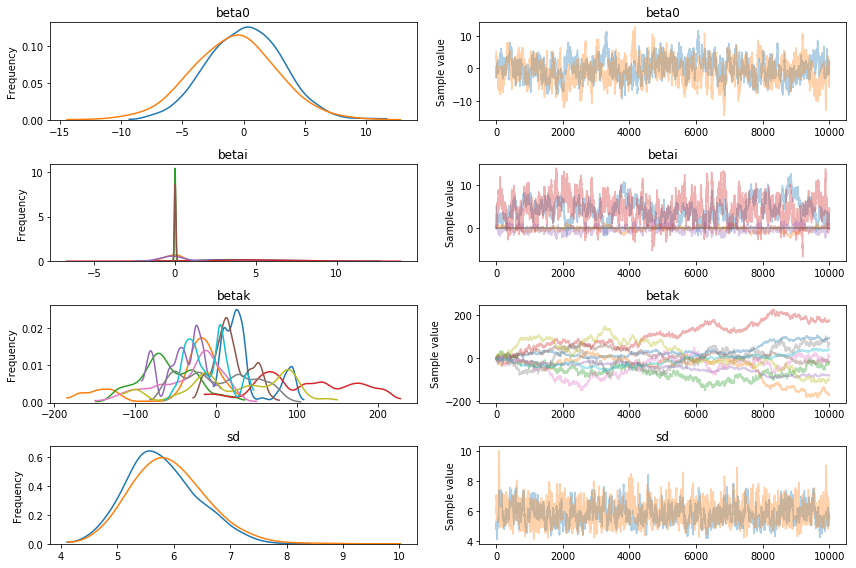

In [204]:
pm.traceplot(chain, varnames=['beta0', 'betai', 'betak', 'sd']);

In [207]:
beta0_est = chain.get_values(varname='beta0', burn=100, thin=2, combine=True)
betai_est = chain.get_values(varname='betai', burn=100, thin=2, combine=True)
betak_est = chain.get_values(varname='betak', burn=100, thin=2, combine=True)
y_est = beta0_est.mean() + np.dot(X, betai_est.mean(axis=0)) + np.dot(K, betak_est.mean(axis=0))
beta0_hpd = pm.hpd(beta0_est, alpha=0.1)
betai_hpd = pm.hpd(betai_est, alpha=0.1)
betak_hpd = pm.hpd(betak_est, alpha=0.1)
y_hpd = beta0_hpd + np.dot(X, betai_hpd) + np.dot(K, betak_hpd)

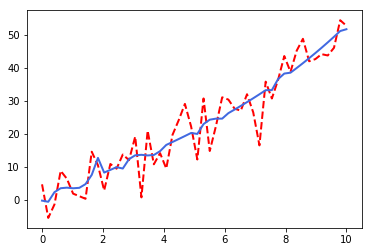

In [209]:
plt.plot(x, y, ls='--', lw=2, c='red')
plt.plot(x, y_est, ls='-', lw=2, c='royalblue')
#plt.fill_between(x, y_hpd[:,0], y_hpd[:,1], color='royalblue', alpha=0.5)
plt.show()

## Cubic spline regression (scipy)

In [129]:
N = 50
x = np.linspace(0., 10., N)
noise = np.random.randn(N)*5.
y = 2. + 0.5*x + x**1.67 + noise

In [130]:
NK = 8
knots = np.linspace(x.min(), x.max(), NK)
# Univariate spline in the B-spline basis
basis_funcs = BSpline(knots, np.eye(NK), k=3)  # cubic spline representation
Bx = basis_funcs(x)  # coefficients

In [140]:
with pm.Model() as splines:
    betai = pm.Normal('betai', mu=0., sd=100., shape=NK)
    mu = pm.Deterministic('mu', pm.math.dot(Bx, betai))
    sd = pm.HalfCauchy('sd', beta=10.)
    yi = pm.Normal('yhat', mu=mu, sd=sd, observed=y)
    chain = pm.sample(draws=11000, tune=2000, chains=2, nuts_kwargs={'target_accept':0.95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sd, betai]


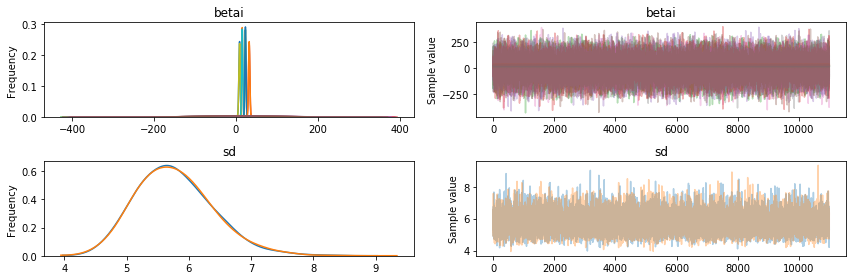

In [143]:
pm.traceplot(chain, varnames=['betai', 'sd']);

In [144]:
betai_est = chain.get_values(varname='betai', burn=1000, thin=2, combine=True)
y_est = np.dot(Bx, betai_est.mean(axis=0))
betai_hpd = pm.hpd(betai_est)
y_hpd = np.dot(Bx, betai_hpd)

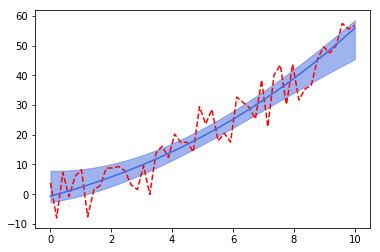

In [145]:
# Interpolation
plt.plot(x, y, ls='--', c='red')
plt.plot(x, y_est, ls='-', c='royalblue')
plt.fill_between(x, y_hpd[:,0], y_hpd[:,1], color='royalblue', alpha=0.5)
plt.show()

In [146]:
# Extrapolation
x_new = np.linspace(5., 15., 50)
Bx_new = basis_funcs(x_new)
y_new = np.dot(Bx_new, betai_est.mean(axis=0))
y_new_hpd = np.dot(Bx_new, betai_hpd)

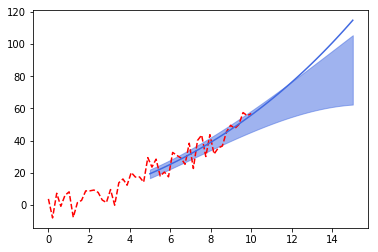

In [147]:
plt.plot(x, y, ls='--', c='red')
plt.plot(x_new, y_new, ls='-', c='royalblue')
plt.fill_between(x_new, y_new_hpd[:,0], y_new_hpd[:,1], color='royalblue', alpha=0.5)
plt.show()

## Hierarchical cubic spline regression 
#### with all y's of the same length and equal no. of knots!

In [6]:
# y1 & y2 moraju imati isti broj elemenata!
y2 = 20. + 0.5*x + x**2.5 + noise*5.
y3 = 1. + x + x**2 + np.sqrt(x**3) + noise*5.

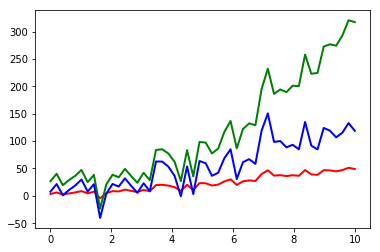

In [7]:
plt.plot(x, y, c='red', ls='-', lw=2)
plt.plot(x, y2, c='green', ls='-', lw=2)
plt.plot(x, y3, c='blue', ls='-', lw=2)
plt.show()

In [138]:
NK = 8
knots = np.linspace(x.min(), x.max(), NK)
# Univariate spline in the B-spline basis
basis_funcs = BSpline(knots, np.eye(NK), k=3)  # cubic spline representation
Bx = basis_funcs(x)  # coefficients

In [136]:
y_all = np.c_[y, y2, y3]  # column stacking observations

In [139]:
with pm.Model() as splines:
    # hyper-priors
    mu0 = pm.Normal('mu0', mu=0., sd=100.)
    sd0 = pm.HalfCauchy('sd0', beta=10.)
    # priors (must use the same NK for y1 & y2!)
    betai = pm.Normal('betai', mu=mu0, sd=sd0, shape=(NK,3))
    sd = pm.HalfCauchy('sd', beta=10.)
    nu = pm.Exponential('nu', lam=1/10.)
    # link (spline regression)
    mu = pm.Deterministic('mu', pm.math.dot(Bx, betai))
    # likelihood
    yi = pm.StudentT('yhat', nu=nu, mu=mu, sd=sd, observed=y_all)
    # MCMC
    chain = pm.sample(draws=11000, tune=2000, chains=2, nuts_kwargs={'target_accept':0.95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [nu, sd, betai, sd0, mu0]


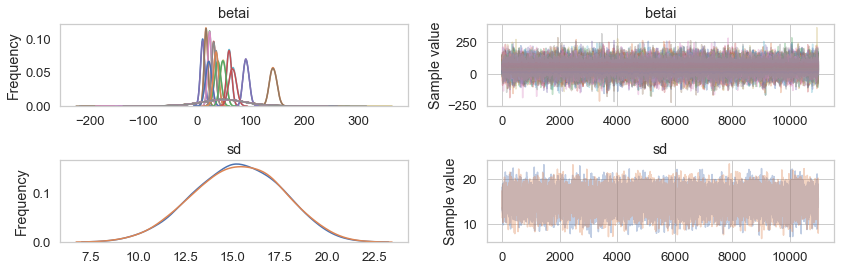

In [140]:
pm.traceplot(chain, varnames=['betai', 'sd']);

In [141]:
betai_est = chain.get_values(varname='betai', burn=1000, thin=2, combine=True)
y_est = np.dot(Bx, betai_est.mean(axis=0))

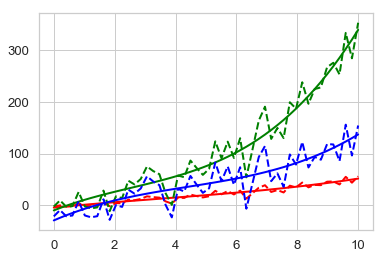

In [143]:
plt.plot(x, y, c='red', ls='--', lw=2)
plt.plot(x, y_est[:,0], ls='-', lw=2, c='red')
plt.plot(x, y2, c='green', ls='--', lw=2)
plt.plot(x, y_est[:,1], ls='-', lw=2, c='green')
plt.plot(x, y3, c='blue', ls='--', lw=2)
plt.plot(x, y_est[:,2], ls='-', lw=2, c='blue')
plt.show()

### Hierarchical Polynomial regression with heterogeneous variances

In [6]:
x = np.linspace(0., 10., 50)
y1 = 0. + 1.*x + 2.*x**2 + np.random.randn(50)*5.
y2 = 3. + 4.*x + 5.*x**2 + np.random.randn(50)*10.
y3 = 6. + 7.*x + 8.*x**2 + np.random.randn(50)*15.

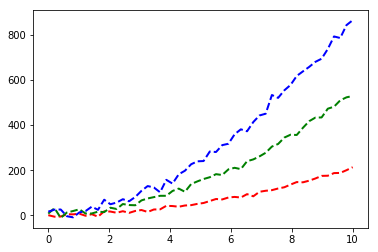

In [7]:
plt.plot(x, y1, c='red', ls='--', lw=2)
plt.plot(x, y2, c='green', ls='--', lw=2)
plt.plot(x, y3, c='blue', ls='--', lw=2)
plt.show()

In [8]:
# x-evi mogu biti razliciti te mogi imati razlicit broj elemenata
xvals = np.r_[x, x, x]
yvals = np.r_[y1, y2, y3]
ind0 = np.zeros_like(x, dtype=np.int)
ind1 = np.ones_like(x, dtype=np.int)
ind2 = np.repeat([2], len(x))
ind = np.r_[ind0, ind1, ind2]

In [9]:
with pm.Model() as poly:
    mu0 = pm.Normal('mu0', mu=0., sd=100.)
    sd0 = pm.HalfCauchy('sd0', beta=10.)
    beta0 = pm.Normal('beta0', mu=mu0, sd=sd0, shape=3)
    beta1 = pm.Normal('beta1', mu=mu0, sd=sd0, shape=3)
    beta2 = pm.Normal('beta2', mu=mu0, sd=sd0, shape=3)
    mu = pm.Deterministic('mu', beta0[ind] + beta1[ind]*xvals + beta2[ind]*xvals**2)
    nu = pm.Exponential('nu', lam=1/10.)
    sd_hier = pm.Uniform('sd_hier', lower=1., upper=50.)
    sd = pm.HalfCauchy('sd', beta=sd_hier, shape=3)
    yi = pm.StudentT('yhat', nu=nu, mu=mu, sd=sd[ind], observed=yvals)
    chain = pm.sample(draws=11000, tune=1000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sd, sd_hier, nu, beta2, beta1, beta0, sd0, mu0]
/home/ps/anaconda2/lib/python2.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


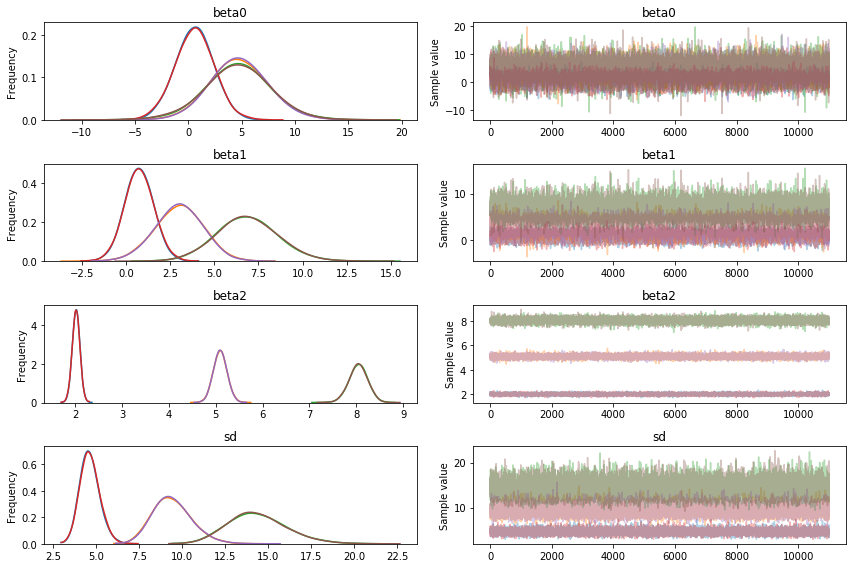

In [10]:
pm.traceplot(chain, varnames=['beta0', 'beta1', 'beta2', 'sd']);

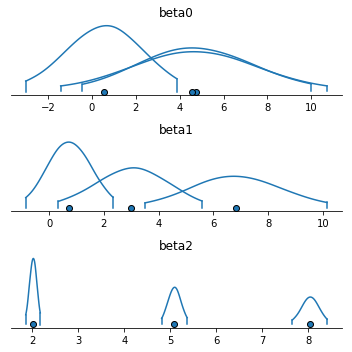

In [11]:
pm.densityplot(chain, varnames=['beta0', 'beta1', 'beta2'], figsize=(5,5));

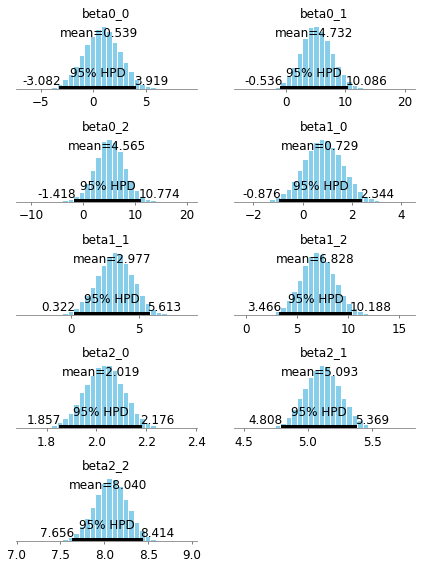

In [12]:
pm.plot_posterior(chain, varnames=['beta0', 'beta1', 'beta2'], figsize=(6,8));

In [13]:
b0 = chain.get_values('beta0', burn=1000, thin=2, combine=True)
b1 = chain.get_values('beta1', burn=1000, thin=2, combine=True)
b2 = chain.get_values('beta2', burn=1000, thin=2, combine=True)

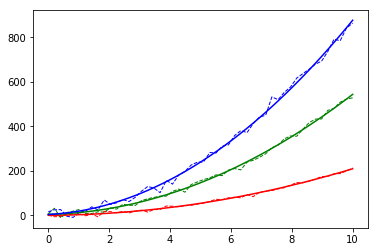

In [15]:
plt.plot(x, y1, c='red', ls='--', lw=1)
plt.plot(x, y2, c='green', ls='--', lw=1)
plt.plot(x, y3, c='blue', ls='--', lw=1)
colors = ['red', 'green', 'blue']
for i in range(3):
    yest = b0.mean(axis=0)[i] + b1.mean(axis=0)[i]*x + b2.mean(axis=0)[i]*x**2
    plt.plot(x, yest, c=colors[i])
plt.show()

## Hierarchical cubic spline regression with heterogenous variances
#### with y's of different length and different no. of knots!
#### THIS is the proper way of doing it!

In [447]:
N1 = 100; N2 = 10
x1 = np.linspace(0., 10., N1)
y1 = 1. + 2.*x1 +x1**1.6 + np.random.randn(N1)*20. 
x2 = np.linspace(2., 8., N2)
y2 = 10. + 0.25*x2 + x2**2.5 + np.random.randn(N2)*50.

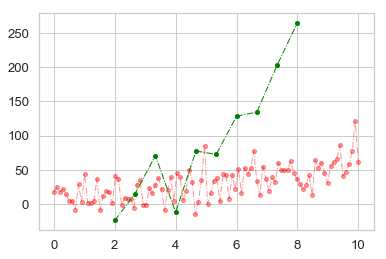

In [448]:
plt.plot(x1, y1, c='red', ls='-.', marker='o', markersize=4, alpha=0.4, lw=1)
plt.plot(x2, y2, c='green', ls='-.', marker='o', markersize=4, lw=1)
plt.show()

In [449]:
NK1 = 16; NK2 = 8  # different no. of knots
knots_1 = np.linspace(x1.min(), x1.max(), NK1)
basis_funcs_1 = BSpline(knots_1, np.eye(NK1), k=3)
Bx1 = basis_funcs_1(x1)  # coefficients 1
knots_2 = np.linspace(x2.min(), x2.max(), NK2)
basis_funcs_2 = BSpline(knots_2, np.eye(NK2), k=3)
Bx2 = basis_funcs_2(x2)  # coefficients 2

In [450]:
# concatenate observations
yall = np.r_[y1, y2]

In [451]:
ind0 = np.zeros_like(y1, dtype=np.int)
ind1 = np.ones_like(y2, dtype=np.int)
ind = np.r_[ind0, ind1]

In [452]:
with pm.Model() as splines:
    # hyper-priors
    b0 = pm.Uniform('b0', lower=1., upper=50.)
    mu0 = pm.Normal('mu0', mu=0., sd=100.)
    sd0 = pm.HalfCauchy('sd0', beta=10.)
    # priors 
    beta1 = pm.Normal('beta1', mu=mu0, sd=sd0, shape=NK1)
    beta2 = pm.Normal('beta2', mu=mu0, sd=sd0, shape=NK2)
    sd = pm.HalfCauchy('sd', beta=b0, shape=2)  # heterogenous variances
    nu = pm.Exponential('nu', lam=1/10.)
    # link (spline regression)
    mu = pm.Deterministic('mu', tt.concatenate([pm.math.dot(Bx1,beta1), pm.math.dot(Bx2,beta2)]) )
    # likelihood
    yi = pm.StudentT('yhat', nu=nu, mu=mu, sd=sd[ind], observed=yall)
    # MCMC
    chain = pm.sample(draws=101000, tune=20000, step=pm.Metropolis(), chains=2)

Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>Metropolis: [nu]
>Metropolis: [sd]
>Metropolis: [beta2]
>Metropolis: [beta1]
>Metropolis: [sd0]
>Metropolis: [mu0]
>Metropolis: [b0]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


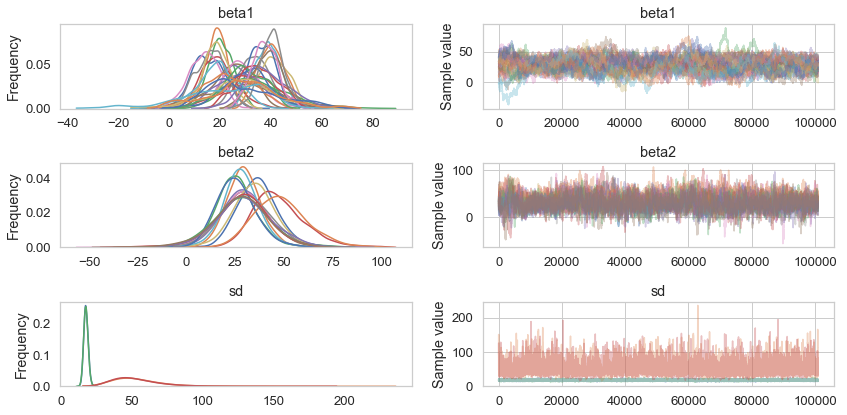

In [453]:
pm.traceplot(chain, varnames=['beta1', 'beta2', 'sd']);

In [454]:
beta1_est = chain.get_values(varname='beta1', burn=20000, thin=20, combine=True)
beta2_est = chain.get_values(varname='beta2', burn=20000, thin=20, combine=True)
yest1 = np.dot(Bx1, beta1_est.mean(axis=0))
yest2 = np.dot(Bx2, beta2_est.mean(axis=0))

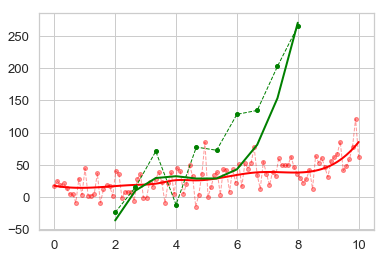

In [455]:
plt.plot(x1, y1, c='red', ls='--', marker='o', markersize=4, alpha=0.4, lw=1)
plt.plot(x1, yest1, ls='-', c='red', lw=2)
plt.plot(x2, y2, c='green', ls='--', marker='o', markersize=4, lw=1)
plt.plot(x2, yest2, ls='-', c='green', lw=2)
plt.show()

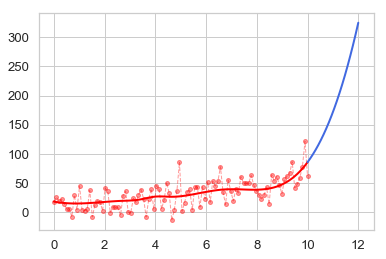

In [457]:
# Extrapolation
x_new = np.linspace(10., 12., 20)
Bx_new = basis_funcs_1(x_new)
y_new = np.dot(Bx_new, beta1_est.mean(axis=0))
plt.plot(x1, y1, c='red', ls='--', marker='o', markersize=4, alpha=0.4, lw=1)
plt.plot(x1, yest1, ls='-', c='red', lw=2)
plt.plot(x_new, y_new, ls='-', c='royalblue', lw=2)
plt.show()

In [458]:
# fit only y2
with pm.Model():
    betak = pm.Normal('betak', mu=0., sd=100., shape=NK2)
    mu = pm.Deterministic('mu', pm.math.dot(Bx2, betak))
    sd = pm.HalfCauchy('sd', beta=10.)
    yi = pm.Normal('yhat', mu=mu, sd=sd, observed=y2)
    ch = pm.sample(draws=11000, tune=2000, chains=2, nuts_kwargs={'target_accept':0.95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sd, betak]


In [459]:
betak_est = ch.get_values(varname='betak', burn=1000, thin=2, combine=True)
y_est = np.dot(Bx2, betak_est.mean(axis=0))
betak_hdi = pm.hpd(betak_est, alpha=0.1)
y_hdi = np.dot(Bx2, betak_hdi)

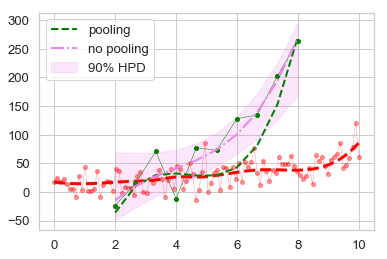

In [462]:
plt.plot(x1, y1, c='red', ls='-', marker='o', markersize=4, alpha=0.4, lw=0.5)
plt.plot(x1, yest1, ls='--', c='red', lw=3)
plt.plot(x2, y2, c='green', ls='-', marker='o', markersize=4, lw=0.5)
plt.plot(x2, yest2, ls='--', c='green', lw=2, label='pooling')
plt.plot(x2, y_est, ls='-.', c='violet', lw=2, label='no pooling')
plt.fill_between(x2, y_hdi[:,0], y_hdi[:,1], color='violet', alpha=0.2, label='90% HPD')
plt.legend(loc='best')
plt.show()

## Multiple regression with cubic splines

In [87]:
# x1 & x2 moraju imati isti broj elemenata!
nnoise = 10. + np.random.randn(50)
x1 = np.linspace(0., 10., 50)
y1 = 2. + 0.5*x1 + x1**1.67 + nnoise*100.
x2 = np.linspace(20., 50., 50)
y2 = 20. + 0.5*x2 + x2**2.2 + nnoise*100.
z = y1 + y2 + np.sqrt(y1*y2)

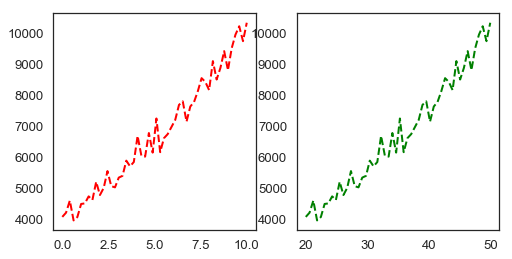

In [88]:
fig, ax = plt.subplots(1, 2, figsize=(8,4))
ax[0].plot(x1, z, c='red', ls='--', lw=2)
ax[1].plot(x2, z, c='green', ls='--', lw=2)
plt.show()

In [95]:
NK1 = 8; NK2 = 10  # different no. of knots
knots_1 = np.linspace(x1.min(), x1.max(), NK1)
basis_funcs_1 = BSpline(knots_1, np.eye(NK1), k=3)
Bx1 = basis_funcs_1(x1)  # coefficients 1
knots_2 = np.linspace(x2.min(), x2.max(), NK2)
basis_funcs_2 = BSpline(knots_2, np.eye(NK2), k=3)
Bx2 = basis_funcs_2(x2)  # coefficients 2

In [96]:
# Koristiti hierarhijski model samo ako su prediktori iz slicnog raspona vrijednosti! 
# Inace, definirati svaki "prior" sam za sebe, npr.:
# beta1 = pm.Normal('beta1', mu=0., sd=100., shape=NK1)
# beta2 = pm.Normal('beta2', mu=0., sd=100., shape=NK2)
# bez koristenja hyper-parametara!
with pm.Model() as multiple:
    # hyper-priors
    mu0 = pm.Normal('mu0', mu=0., sd=100.)
    sd0 = pm.HalfCauchy('sd0', beta=10.)
    # priors
    beta1 = pm.Normal('beta1', mu=mu0, sd=sd0, shape=NK1)
    beta2 = pm.Normal('beta2', mu=mu0, sd=sd0, shape=NK2)
    sd = pm.HalfCauchy('sd', beta=10.)
    nu = pm.Exponential('nu', lam=1/10.)
    # link function (cubic splines regression)
    mu = pm.Deterministic('mu', pm.math.dot(Bx1, beta1) + pm.math.dot(Bx2, beta2))  # sum
    # likelihood
    yi = pm.StudentT('yhat', nu=nu, mu=mu, sd=sd, observed=z)
    chain = pm.sample(draws=101000, tune=20000, chains=2, step=pm.Metropolis())
                      #nuts_kwargs={'target_accept':0.95, 'max_treedepth':20})

Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>Metropolis: [nu]
>Metropolis: [sd]
>Metropolis: [beta2]
>Metropolis: [beta1]
>Metropolis: [sd0]
>Metropolis: [mu0]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


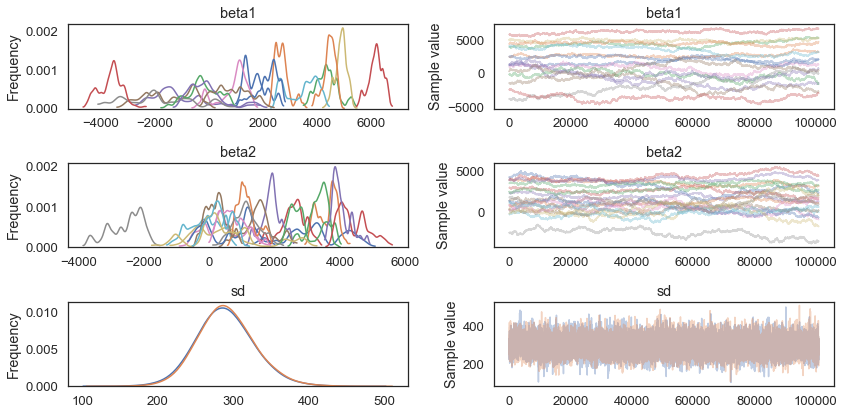

In [97]:
pm.traceplot(chain, varnames=['beta1', 'beta2', 'sd']);

In [98]:
beta1_est = chain.get_values(varname='beta1', burn=20000, thin=20, combine=True)
beta2_est = chain.get_values(varname='beta2', burn=20000, thin=20, combine=True)
y_est = np.dot(Bx1, beta1_est.mean(axis=0)) + np.dot(Bx2, beta2_est.mean(axis=0))

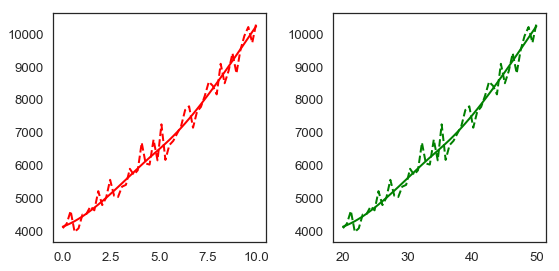

In [99]:
fig, ax = plt.subplots(1, 2, figsize=(8,4))
ax[0].plot(x1, z, c='red', ls='--', lw=2)
ax[0].plot(x1, y_est, c='red', ls='-', lw=2)
ax[1].plot(x2, z, c='green', ls='--', lw=2)
ax[1].plot(x2, y_est, c='green', ls='-', lw=2)
fig.tight_layout()
plt.show()

### Simple example

In [17]:
import scipy.stats as stats

In [18]:
t1 = stats.bernoulli(0.7).rvs(50)
t2 = stats.bernoulli(0.3).rvs(20)

In [19]:
tall = np.r_[t1, t2]
ind0 = np.zeros_like(t1, dtype=np.int)
ind1 = np.ones_like(t2, dtype=np.int)
ind = np.r_[ind0, ind1]

In [21]:
with pm.Model() as two_groups:
    theta = pm.Beta('theta', alpha=0.001, beta=0.001, shape=2)
    yi = pm.Bernoulli('y', p=theta[ind], observed=tall)
    chain = pm.sample(10000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


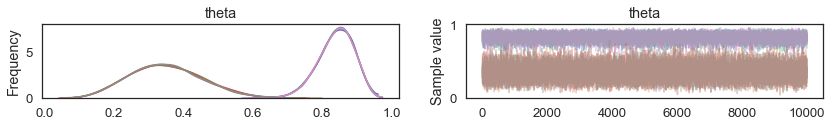

In [22]:
pm.traceplot(chain);